# Mint

## Set Up

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import re
import json
import pickle
import pandas as pd
from pathlib import Path

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import sys
# Add the workspace root to sys.path so 'scripts' can be imported
sys.path.append(str(Path.cwd().parents[3]))

from scripts.feature_extractions.tf_idf import get_tf_idf_vector


In [3]:
PATH = Path.cwd().parents[3]
MODEL_PATH = os.path.join(PATH, 'models/baseline')
DATA_PATH = os.path.join(PATH, 'data')
EX_PATH = os.path.join(DATA_PATH, 'external/crpwarner/large')
SOL_PATH = os.path.join(EX_PATH, 'sol')

## Load and Prepare Data

In [4]:
df = pd.read_excel(os.path.join(EX_PATH, 'sample/mint.xlsx'))
df['Address'] = df['Address'].str.lower()
df = df.set_index('Address')
df.head()

,TP?
Address,
0x0fef20d2c4ee011fa0389e69e9fa92a2291b63c8,Yes
0xd7cc0deb9dd11be95068bf2d7a3d082b8ba9bf04,Yes
0xa1b756be589441519b1a08e16bc4f60ab177d916,Yes
0x514bc174df04a4b04ae2be81ee8c788c3796b06b,Yes
0x1354c8c1a66c2573ce9cc3e92e98d17869501a46,Yes


In [5]:
df.isna().sum()

TP?    0
dtype: int64

In [6]:
files = []
y = []

for path in list(Path(SOL_PATH).glob('*.sol')):
    address = path.stem.lower()
    if address in df.index:
        files.append(path)
        y.append(1 if df.loc[address, 'TP?'] == 'Yes' else 0)

X, val_cols = get_tf_idf_vector(files)

100%|██████████| 92/92 [00:00<00:00, 1578.86it/s]


In [7]:
X

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 23046 stored elements and shape (92, 4262)>

In [8]:
len(val_cols)

4262

In [9]:
X = pd.DataFrame(X.toarray(), columns=val_cols)
X.head()

,pragma,solidity,0,4,16,contract,owned,address,public,owner,...,通过调用服务合约的transferfrom,销毁代币,从其他账户销毁代币,tfcoin,冻结账户,转账,比父类加入了账户冻结,向指定账户增发资金,冻结,解冻账户
0,0.082123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.065606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.041665,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.119183,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.079259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
y[:5]

[1, 0, 1, 1, 1]

In [11]:
with open(os.path.join(DATA_PATH, 'processed/tf_idf/feature_sol.json'), 'r', encoding='utf-8') as f:
    train_cols = json.load(f)

In [12]:
missing_in_val = set(val_cols) - set(train_cols)
extra_in_val = set(train_cols) - set(val_cols)

print(f"\nMissing in X_val ({len(missing_in_val)}): {missing_in_val}")
print(f"Extra in X_val ({len(missing_in_val)}): {extra_in_val}")


Missing in X_val (2795): {'devethdestination', 'safesubtract', 'gettokensholder', 'enablebuyback', '1440', 'suite', 'tokensforcrowdsale', 'setmigratecontract', '_amountinethers', 'leap_year_in_seconds', 'incentivize', '42', 'matches', 'flowchain', 'slicing', 'procurement', 'divisble', 'period2', 'kamen', 'nameid', 'bountysupply', 'stq', 'setvestingwithdefaultschedule', 'addressutils', 'saves', '_limit', 'stuck', '冻结总额', 'paymentallowed', 'crowdsale', 'min64', '_referral', 'lrcamount', 'withdrawlrc', 'mintabletoken', 'ether_value', 'addlockaddress', 'calculating', 'capitulation', 'year', 'russian', 'setsalecap', 'fundtransfer', 'miner', 'bst', '检测发送者是否有足够的资金', 'draper', 'rentrancy', 't12345', 'evenly', 'hackers', 'regulation', '到期自动解冻', 'advisory', 'contractstate', '_multiplier', 'modifications', 'senderislistener', 'going', '转账eth', '_vaultaddress', '_currentprimordialbalance', 'issuetoken', 'currentchange', 'bonuscount', 'batchadddepositrecordsbyowner', 'admin_', 'totalvalue', 'icon'

In [13]:
X = X.reindex(columns=train_cols, fill_value=0).reset_index(drop=True)
X.head()

,spdx,license,identifier,mit,pragma,solidity,0,6,12,import,...,setmaster,syncpair,rewardholders,_issuper,_getethequivalent,bought,sold,soldeth,_hasliquidity,amounttokens
0,0,0.0,0,0,0.082123,0.0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0.0,0,0,0
1,0,0.0,0,0,0.065606,0.0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0.0,0,0,0
2,0,0.0,0,0,0.041665,0.0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0.0,0,0,0
3,0,0.0,0,0,0.119183,0.0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0.0,0,0,0
4,0,0.0,0,0,0.079259,0.0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0.0,0,0,0


## Load Model and Evaluate

In [14]:
model_paths = list(Path(MODEL_PATH).glob('mint-*.pkl'))

In [15]:
def get_best_model_path(paths):
    best_f1_score = -1.0
    best_path = None

    for path in paths:
        # Extract the F1 score using a regular expression
        match = re.search(r'f1-(\d+\.\d+)\.(pkl|json|keras)$', path.name)
        if match:
            try:
                f1_score = float(match.group(1))
                if f1_score > best_f1_score:
                    best_f1_score = f1_score
                    best_path = path
            except ValueError:
                # Handle cases where the extracted string might not be a valid float
                print(f"Warning: Could not parse F1 score from filename: {path.name}")
        else:
            print(f"Warning: F1 score pattern not found in filename: {path.name}")

    return best_path

In [16]:
best_model_path = get_best_model_path(model_paths)

if best_model_path:
    model = pickle.load(open(best_model_path, 'rb'))

In [17]:
y_pred = model.predict(X)

In [18]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.15      1.00      0.27        14
           1       1.00      0.01      0.03        78

    accuracy                           0.16        92
   macro avg       0.58      0.51      0.15        92
weighted avg       0.87      0.16      0.06        92



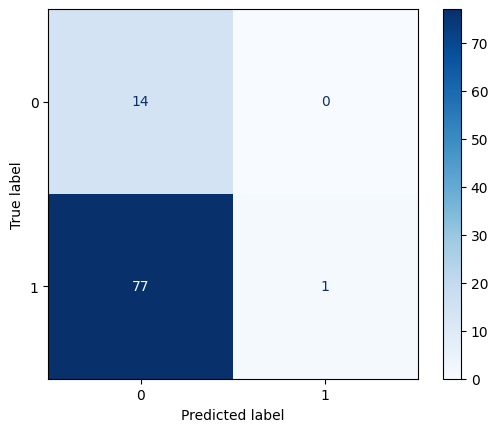

In [19]:
cm = confusion_matrix(y, y_pred)
cm_display = ConfusionMatrixDisplay(cm)
cm_display.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()